In [129]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import seaborn as sns

def rosenbrock(coords):
    x, y = coords
    a = 0
    b = 1
    return (a-x)**2 + b*(y-x**2)**2

def rastrigin(coords):
    x, y = coords
    n = 2
    return 10*n + (x**2 - 10*np.cos(2*np.pi*x)) + (y**2 - 10*np.cos(2*np.pi*y))

def binary2xy(binary_number):

    # split into xy
    size = len(binary_number)//2
    x = binary_number[:size] 
    y = binary_number[size:]

    # first character will determine the xy sign
    character2sign_map = {'0': -1, '1': 1}
    x = character2sign_map[x[0]] * int(x[1:], 2) 
    y = character2sign_map[y[0]] * int(y[1:], 2) 

    return x,y

def crossover_parents(parents, individual_size):

    parent1, parent2 = parents
    crossover_index = random.randint(1, individual_size - 1)

    parent1_first_chunk = parent1[:crossover_index]
    parent1_second_chunk = parent1[crossover_index:]
    parent2_first_chunk = parent2[:crossover_index]
    parent2_second_chunk = parent2[crossover_index:]

    child1 = parent1_first_chunk + parent2_second_chunk
    child2 = parent2_first_chunk + parent1_second_chunk

    return child1, child2

def mutate(individual, p):
 
    original_individual = [i for i in individual]# individual.split().copy()
    mutated_individual = original_individual.copy()
    mutation_map = {'0':'1', '1':'0'}
    for i, gene in enumerate(original_individual):
        if random.uniform(0, 1) <= p:
            mutated_individual[i] = mutation_map[gene]  

    return ''.join(mutated_individual)

def genetic_optimize(target_function, 
                     population_size=20, 
                     individual_size=16, 
                     crossover_rate=0.02, 
                     mutation_rate=0.02):

    # initiate other parameters
    population_size = population_size
    individual_size = individual_size
    crossover_rate = crossover_rate
    mutation_rate = mutation_rate
    max_iterations = 250
    costs = []
    generations = []

    # initiate random population
    generation = [''.join(random.choices(['0', '1'], k=individual_size)) for _ in range(population_size)]
    # generations.append(generation)

    # loop until max iterations
    for _ in range(max_iterations):

        # evaluate individuals
        decoded_individuals = [binary2xy(individual) for individual in generation] 
        generation_cost = [target_function(dcd_individual) for dcd_individual in decoded_individuals]
        costs.append(generation_cost)
        total_generation_cost = sum(generation_cost)

        if total_generation_cost == 0:
            break

        ranked_generation = [idv for fitness, idv in sorted(zip(generation_cost, generation))]
        ranked_costs = sorted(generation_cost)
        
        # perform selection 
        generation_cost_probabilities = [cost/total_generation_cost for cost in ranked_costs]
        generation_cost_minimize = [1 - maxim_prob for maxim_prob in generation_cost_probabilities]
        probabilities = [cost/sum(generation_cost_minimize) for cost in generation_cost_minimize]
        cumulative_probabilities = np.cumsum(probabilities)
        
        # parent selection
        new_generation = []
        for _ in generation:
            for j, p in enumerate(cumulative_probabilities):
                if random.random() <= p:
                    new_generation.append(ranked_generation[j])
                    break
        
        # parent pairing
        new_generation_parent_pairs = []
        for i in range(0, len(new_generation), 2):
            new_generation_parent_pairs.append((new_generation[i], new_generation[i+1]))
            if i == len(new_generation) - 3:
                break
        
        # perform crossover
        new_generation = []
        for parents in new_generation_parent_pairs:
            if random.uniform(0, 1) <= crossover_rate:
                new_generation.extend(crossover_parents(parents, individual_size))
            else:
                new_generation.extend(parents)

        # perform mutation
        generation = [mutate(idv, mutation_rate) for idv in new_generation] 
        generations.append(generation)

    return generations, costs

In [88]:
population_size = 12  #@param {type: "slider", min: 2, max: 100}
individual_size = 12  #@param {type: "slider", min: 4, max: 100}
crossover_rate = 0.025 #@param {type:"slider", min:0, max:1, step:0.025}
mutation_rate = 0.025 #@param {type:"slider", min:0, max:1, step:0.025}

In [106]:
def run_experiment(target_function, population_size, individual_size, crossover_rate, mutation_rate, experiment_repetitions):

    # Initializing the variables for tracking
    max_costs_distribution = []
    min_costs_distribution = []
    median_costs_distribution = []
    repetition = []
    generation = []

    # Repeat the experiment and store values
    for i in range(experiment_repetitions):
        repetition.append(i)
        generations, costs = genetic_optimize(target_function, 
                                            population_size=population_size,
                                            individual_size=individual_size,
                                            crossover_rate=crossover_rate,
                                            mutation_rate=mutation_rate)
        generation.append([i for i, _ in enumerate(costs)])
        min_costs_distribution.append([min(c) for c in costs])
        max_costs_distribution.append([max(c) for c in costs])
        median_costs_distribution.append([np.median(c) for c in costs])

    # Wrangling results data to fit the visualization format
    repetition = [[i]*len(gens) for i, gens in enumerate(generation)]
    repetition = [x for rep in repetition for x in rep]
    generation = [x for rep in generation for x in rep]
    min_costs_distribution = [x for rep in min_costs_distribution for x in rep]
    max_costs_distribution = [x for rep in max_costs_distribution for x in rep]
    median_costs_distribution = [x for rep in median_costs_distribution for x in rep]
    df = pd.DataFrame(zip(repetition, generation, min_costs_distribution, max_costs_distribution, median_costs_distribution), 
                      columns=['repetition', 'generation', 'min_costs_distribution', 'max_costs_distribution', 'median_costs_distribution'])         
    
    # Plotting the results
    plt.figure(figsize=(10, 8))
    ax = sns.lineplot(data=df, x='generation', y='min_costs_distribution', label='min_costs_distribution')
    sns.lineplot(data=df, x='generation', y='max_costs_distribution', label='max_costs_distribution')
    plt.legend()
    plt.ylabel('Fitness')
    plt.xlabel('Generation Nº')
    plt.title(f'Min/Max Generation Fitness for {experiment_repetitions} repeated experiments over {target_function.__name__} function')
    plt.show();

    plt.figure(figsize=(10, 8))
    sns.lineplot(data=df, x='generation', y='median_costs_distribution', label='median_costs_distribution')
    plt.legend()
    plt.ylabel('Fitness')
    plt.xlabel('Generation Nº')
    plt.title(f'Median Generation Fitness for {experiment_repetitions} repeated experiments over {target_function.__name__} function')
    plt.show();

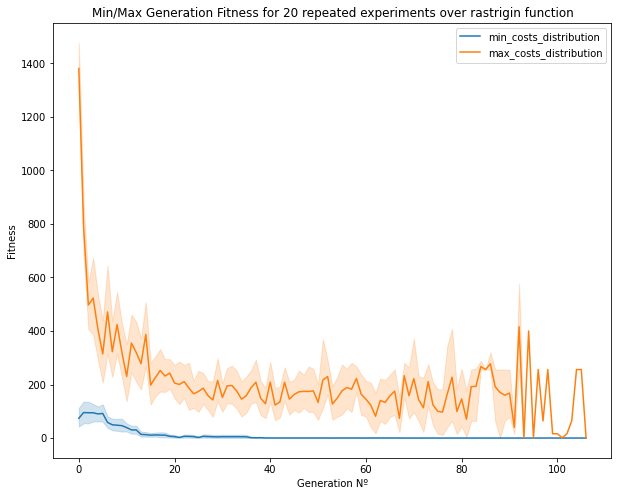

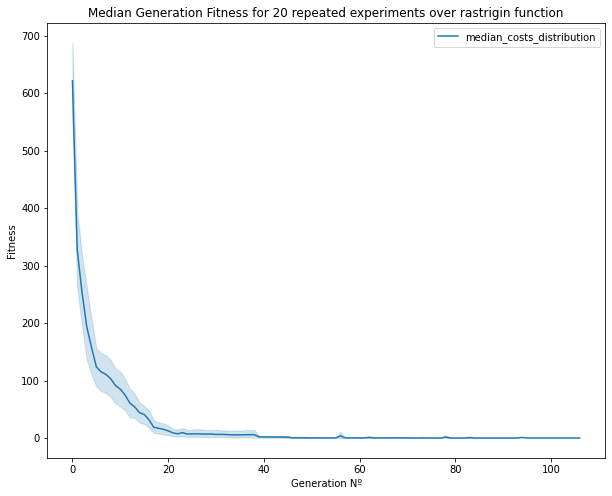

In [107]:
run_experiment(target_function=rastrigin, 
                population_size=population_size,
                individual_size=individual_size,
                crossover_rate=crossover_rate,
                mutation_rate=mutation_rate, 
experiment_repetitions=20)

In [130]:
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
from IPython.core.display import HTML
from matplotlib import cm
    
def update(i, data, graph):
    graph._offsets3d = (data[i][0], data[i][1], data[i][2])
    graph.axes.view_init(azim=2*i)
    # ax.view_init(azim=angle)

def generate_visualization(data, function, save=True, alpha=0.5, file_name='animation'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = np.arange(-2, 2, 0.25)
    ys = np.arange(-2, 2, 0.25)
    X, Y = np.meshgrid(xs, ys)

    Z = function(X, Y)

    ax.plot_surface(X, Y, Z, alpha=alpha, cmap=cm.magma)
    graph = ax.scatter(data[0][0], data[0][1], data[0][2], c='black', s=10, alpha=0.7)


    # Number of iterations
    iterations = len(data)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Animated Scatter Example')
    ax.view_init(25, 10)

    fps = 10
    ani = animation.FuncAnimation(fig, 
                                  update, 
                                  iterations,
                                  fargs=(data, graph),
                                  interval=1000/fps)

    if save:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=fps, 
                        extra_args=['-vcodec', 'libx264'])
        ani.save(f'{file_name}.mp4', writer=writer)

    return ani

In [131]:
generations, costs = genetic_optimize(rosenbrock, 
                                    population_size=population_size,
                                    individual_size=individual_size,
                                    crossover_rate=crossover_rate,
                                    mutation_rate=mutation_rate)

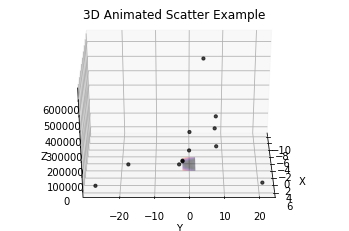

In [134]:
x_data = [np.array([binary2xy(bn) for bn in gen])[:, 0].tolist() for gen in generations]
y_data = [np.array([binary2xy(bn) for bn in gen])[:, 1].tolist() for gen in generations]
viz_data = [[x, y_data[i], costs[i]]for i, x in enumerate(x_data)]

def rosenbrock(x, y):
    a = 0
    b = 1
    return (a-x)**2 + b*(y-x**2)**2
    
ani = generate_visualization(np.array(viz_data), rosenbrock, file_name='rosenbrock_pso');

HTML(ani.to_html5_video())